# Comparison between observations and sea level projections 2

This notebook includes the results of AR6 and CMIP6 wich was not the case in the number 1

In [2]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

sys.path.append('/Users/dewilebars/Projects/SLBudget/code/')
import SeaLevelContrib as slc
sys.path.append('../code')
import func_postpro as postpro

In [3]:
importlib.reload(slc)
importlib.reload(postpro)

<module 'func_postpro' from '/Users/dewilebars/Projects/Project_ProbSLR/SLProj/notebooks/../code/func_postpro.py'>

In [4]:
#path_fig = '/Users/dewilebars/Projects/KNMIClimateScenarios2021-2023/KNMI21/projections/figures/'
path_fig = '../figures/'

### Read tide gauge and projection data

In [5]:
tg_id = [20, 22, 23, 24, 25, 32]
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-5:]

,20,22,23,24,25,32,Average
time,,,,,,,
2017,16.349375,20.646835,15.501911,21.975796,17.292357,16.918,18.114046
2018,11.849375,14.846835,8.801911,12.275796,7.092357,10.118,10.830712
2019,16.849375,21.146835,17.001911,21.275796,16.392357,14.218,17.814046
2020,17.549375,20.946835,16.901911,22.275796,17.692357,14.818,18.364046
2021,16.349375,20.146835,14.101911,19.975796,14.092357,12.818,16.247379


<AxesSubplot: xlabel='time'>

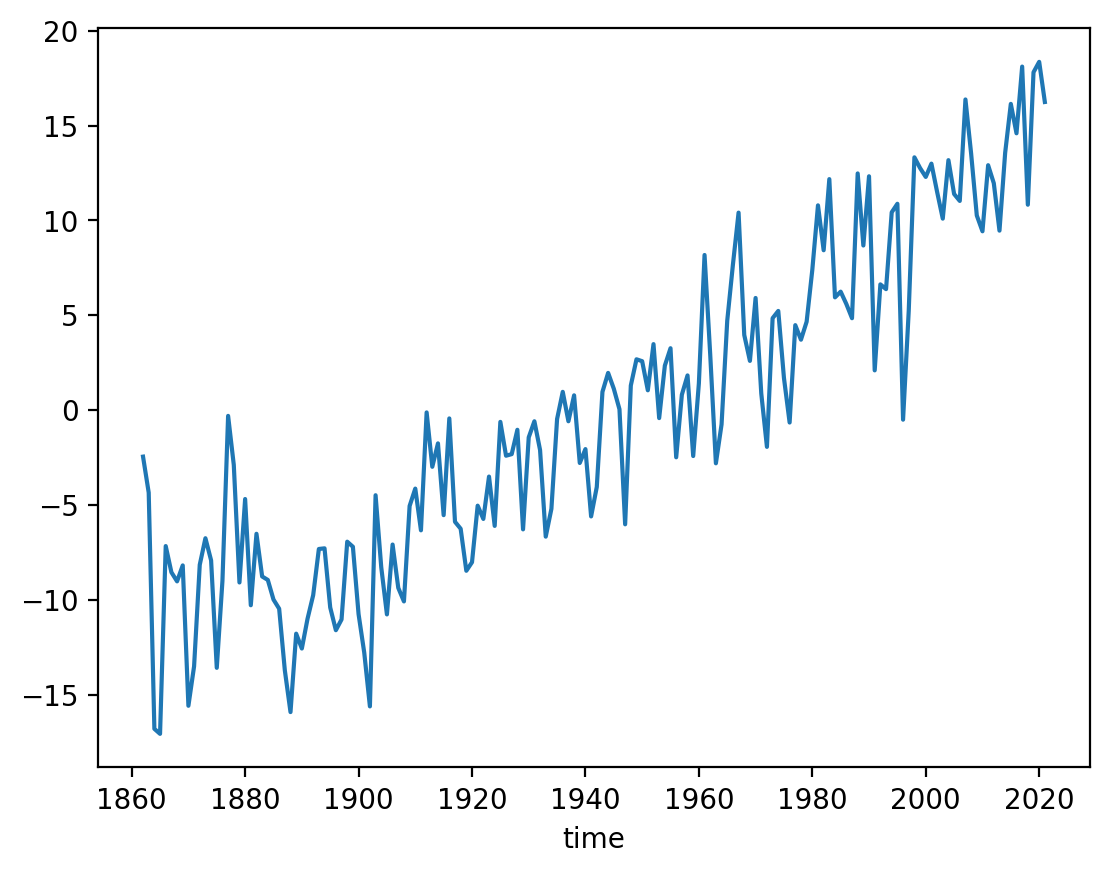

In [6]:
tg_df.Average.plot()

In [7]:
# Standard KNMI14 csv data file
KNMI14_df = postpro.read_knmi14(add_subsidence=True)
KNMI14_df[:5]

,low_05,low_95,high_05,high_95,low_05_sub,low_95_sub,high_05_sub,high_95_sub
year,,,,,,,,
1995,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990,-0.2826,0.3990
1996,0.1787,0.7226,0.1814,0.7251,0.2237,0.7676,0.2264,0.7701
1997,0.3832,1.3960,0.5654,1.5800,0.4732,1.4860,0.6554,1.6700
1998,0.5978,1.6610,0.9111,1.9760,0.7328,1.7960,1.0461,2.1110
1999,0.6499,2.0520,1.2050,2.6090,0.8299,2.2320,1.3850,2.7890


In [8]:
# KNMI14 projections including components info
# Info on the "level" index: 
# mean, p05, p10, p50, p90, p95, last column not used.
path_KNMI14 = '/Users/dewilebars/Projects/Project_ProbSLR/KNMI14/'
KNMI14_high_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_high_V8.nc', 
                                 decode_times=False)
KNMI14_low_ds = xr.open_dataset(path_KNMI14 + 
                    '/ComponentInfo/ENS_knmi_NORTHSEA_slscen_low_V8.nc', 
                                decode_times=False)
KNMI14_high_ds['time'] = KNMI14_high_ds.time + 1950
KNMI14_low_ds['time'] = KNMI14_low_ds.time + 1950

In [9]:
def KNMI14_ds2df(ds,level=3):
    '''Extract the time series of contributors from a sea level projection 
    xarray dataset and build a pandas dataframe. Inputs are a dataset and 
    the percentile to extract.
    Info on the "level" index: 
    0:mean, 1:p05, 2:p10, 3:p50, 4:p90, 5:p95, 6:not used.
    '''
    variables = ['total', 'smb_gre', 'smb_aa', 'gic', 'ibe', 'steric', 
                 'dyn_gre', 'dyn_aa', 'groundw','tglob']
    
    df = pd.DataFrame()
    for idx, val in enumerate(variables):
        if val == 'tglob':
            df[val] = ds[val][:,0,0,0]
        else:
            df[val] = ds[val][:,level,0,0]*100 # Convert from m to cm

    df['time'] = ds.time
    df = df.set_index('time')
    return df

KNMI14_high_df = KNMI14_ds2df(KNMI14_high_ds, 3)
KNMI14_low_df = KNMI14_ds2df(KNMI14_low_ds, 3)

In [10]:
def read_proj(sce, name):
    '''Read projection data and add subsidence'''
    
    if name == 'KNMI14':
        proj_data_dir = '../outputs/ref_proj/'
    else:
        proj_data_dir = '../outputs/KNMIsignal_v3/'
        
    proj_ds = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_{name}_{sce}.nc')
    subsidence = (np.arange(len(proj_ds.time))+10) * 0.045
    sub_2d = np.repeat(subsidence[:,np.newaxis], 
                       repeats=len(proj_ds.percentiles), axis=1)
    sub_2d = np.swapaxes(sub_2d,0,1)
    tot_sub = sub_2d+proj_ds.perc_ts.sel(proc='Total').values
    sub = np.concatenate([sub_2d[np.newaxis,:,:],  tot_sub[np.newaxis,:,:]],
                         axis=0)
    proj_sub = xr.DataArray(sub, dims=proj_ds.perc_ts.dims, 
                            coords=[['Subsidence', 'Total_with_sub'], 
                                    proj_ds.percentiles, proj_ds.time])
    proj_sub = xr.concat([proj_ds.perc_ts, proj_sub], dim='proc')
    
    return proj_sub


In [11]:
KNMIsig_sub = read_proj('ssp245', 'KNMIsignal')
KNMIsigBNW_sub = read_proj('ssp245', 'KNMIsignal_BiasCorr_NoWind')
KNMIsigBWW_sub = read_proj('ssp245', 'KNMIsignal_BiasCorr_WithWind')
KNMI14_sub = read_proj('rcp45', 'KNMI14')

### Comparison plots

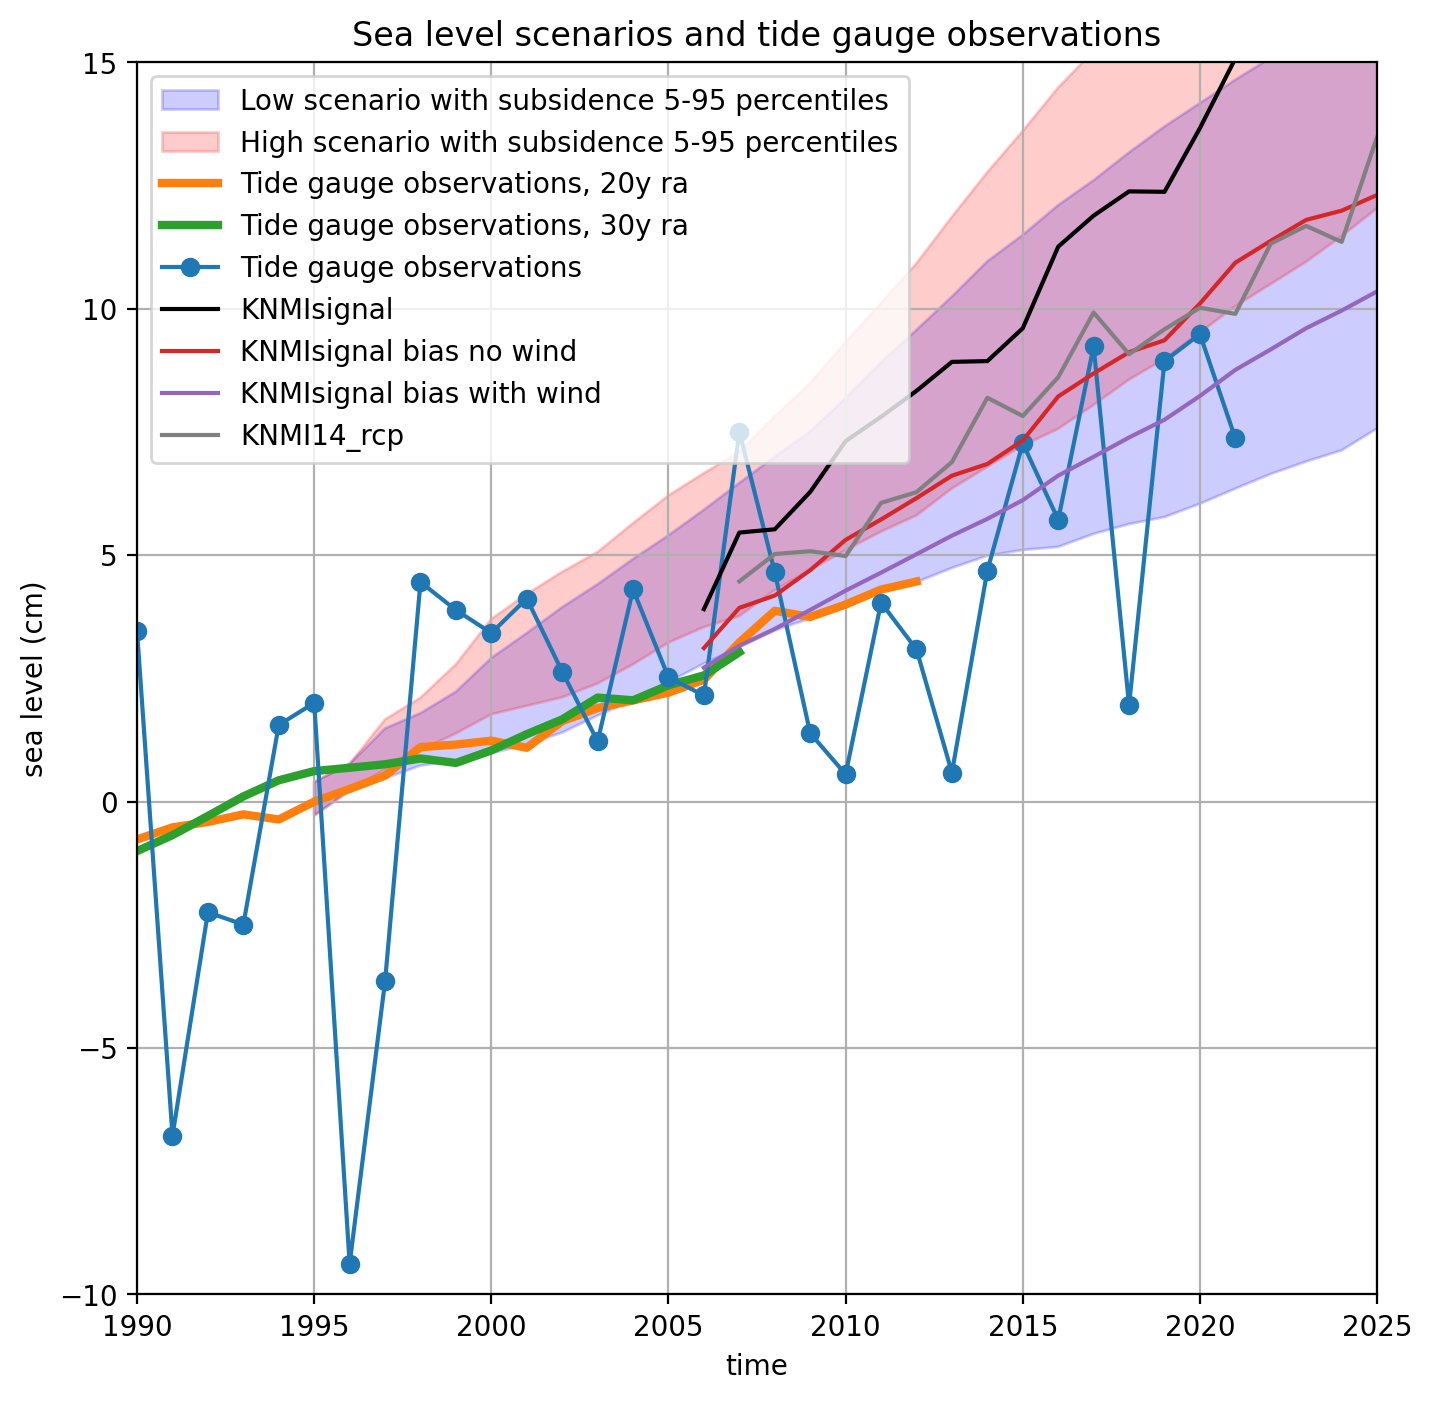

In [12]:
tg_avg_20ra = tg_df['Average'].rolling(20, center=True).mean()
tg_avg_30ra = tg_df['Average'].rolling(30, center=True).mean()
ref = tg_avg_20ra.loc[1995]

#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='blue',alpha=0.2,
               label='Low scenario with subsidence 5-95 percentiles')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='red',alpha=0.2,
               label='High scenario with subsidence 5-95 percentiles')

ax.plot(tg_avg_20ra - ref, '-', color='tab:orange', label='Tide gauge observations, 20y ra', linewidth=3)
ax.plot(tg_avg_30ra - ref, '-', color='tab:green', label='Tide gauge observations, 30y ra', linewidth=3)
ax.plot(tg_df['Average'] - ref, 'o-', color='tab:blue', label='Tide gauge observations')

KNMIsig_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='black', label='KNMIsignal')
KNMIsigBNW_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='tab:red', label='KNMIsignal bias no wind')
KNMIsigBWW_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='tab:purple', label='KNMIsignal bias with wind')
KNMI14_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='grey', label='KNMI14_rcp')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig(path_fig+'comp_timeseris.pdf', dpi=150)

Select less projections

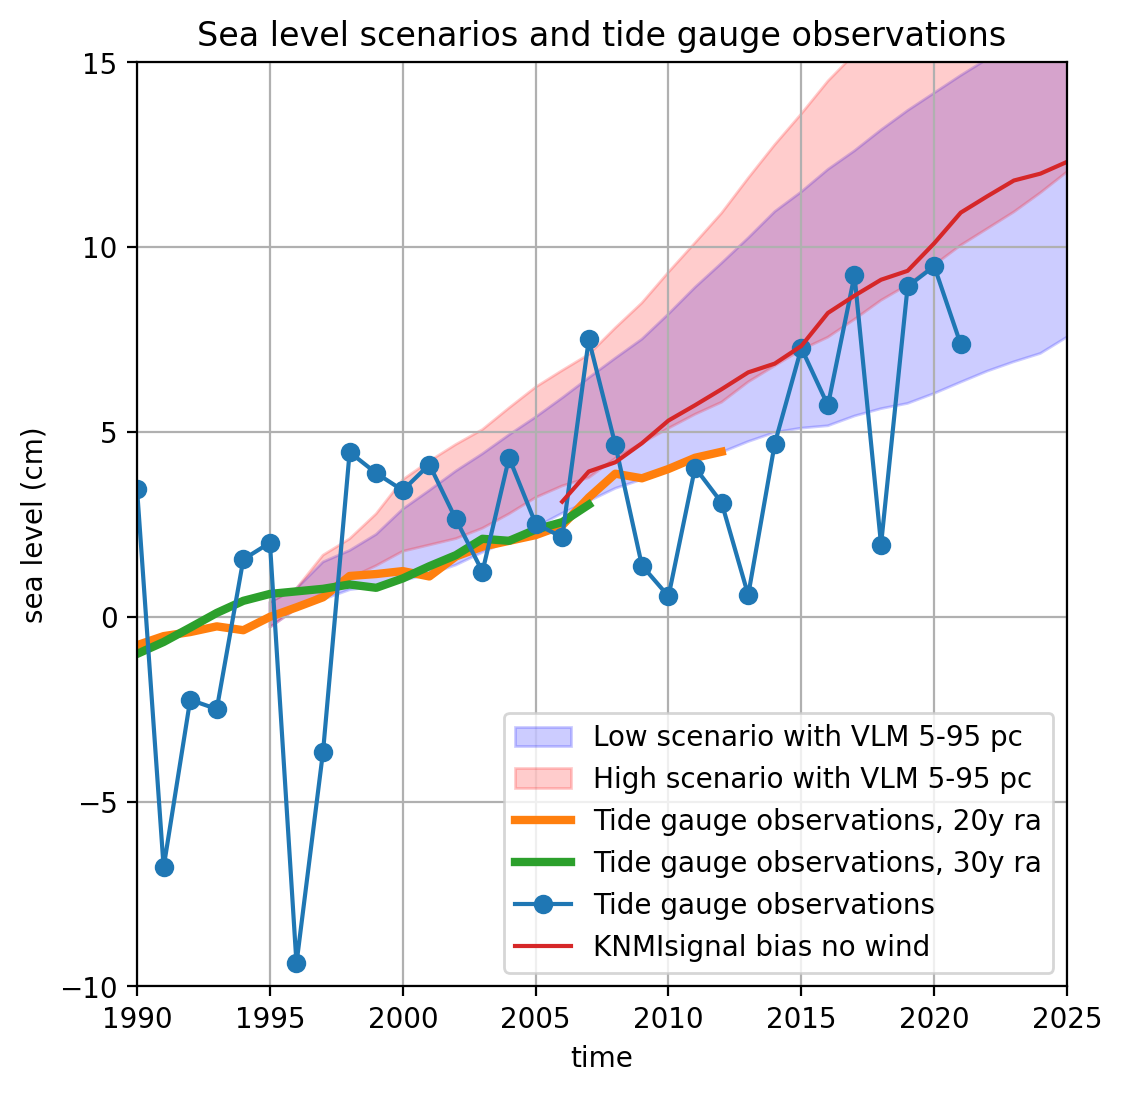

In [13]:
#Plot time series
fig, ax = plt.subplots(figsize=(6,6))
ax.fill_between(KNMI14_df.index, KNMI14_df['low_05_sub'], 
                KNMI14_df['low_95_sub'], color='blue',alpha=0.2,
               label='Low scenario with VLM 5-95 pc')
ax.fill_between(KNMI14_df.index, KNMI14_df['high_05_sub'], 
                KNMI14_df['high_95_sub'], color='red',alpha=0.2,
               label='High scenario with VLM 5-95 pc')

ax.plot(tg_avg_20ra - ref, '-', color='tab:orange', label='Tide gauge observations, 20y ra', linewidth=3)
ax.plot(tg_avg_30ra - ref, '-', color='tab:green', label='Tide gauge observations, 30y ra', linewidth=3)
ax.plot(tg_df['Average'] - ref, 'o-', color='tab:blue', label='Tide gauge observations')

KNMIsigBNW_sub.sel(proc='Total_with_sub', percentiles=[50]).plot(color='tab:red', label='KNMIsignal bias no wind')

#ax.set_aspect(1)
#ax.set_xlim([1950,2030])
#ax.set_ylim([-5,35])
ax.set_xlim([1990,2025])
ax.set_ylim([-10,15])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Sea level scenarios and tide gauge observations')
ax.grid(True)
plt.legend(loc='lower right')

#plt.savefig(f'{path_fig}Comp_TG_KNMI14_KS21.pdf', dpi=150)

### Compare with a budget

In [14]:
path_slb = '/Users/dewilebars/Projects/SLBudget/outputs/'
# budget_df = pd.read_csv(path_slb+
#                         'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv')
budget_df = pd.read_csv(path_slb+
                        'slbudget_2022_06_14_ZSM_1950_2020_ERA5_StericIAP_2000m.csv')

budget_df = budget_df.set_index('time')
budget_df.iloc[-10:]

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
2011,9.987189,2.527546,3.987375,2.246833,2.344167,0.609167,0.207500,-0.831667,-0.515180,0.667331,-1.255883,13.018372
2012,9.068462,2.397512,4.151253,2.283667,2.346667,0.634167,0.220000,-0.498333,-0.696562,-1.166202,-0.603706,12.068372
2013,5.376358,2.279190,4.344560,2.320500,2.403333,0.704167,0.229167,-0.303333,-0.859489,-5.038583,-0.703153,9.568372
2014,7.620545,2.222541,4.500302,2.357333,2.459167,0.769167,0.235000,-0.575000,-0.985564,-3.714982,0.352580,13.668372
2015,12.474820,2.120434,4.707769,2.394167,2.531667,0.864167,0.248333,-0.350000,-1.060552,2.425422,-1.406587,16.251706
2016,8.206191,2.283341,4.680546,2.431000,2.585833,0.835000,0.261667,-0.140000,-1.075985,-2.708465,-0.946746,14.701706
2017,12.636035,2.268953,4.838131,2.467833,2.657500,0.850833,0.269167,-0.684167,-1.030123,1.906213,-0.908306,18.218372
2018,7.042769,2.361251,4.889651,2.504667,2.677500,0.959167,0.276667,-0.811667,-0.928142,-4.027354,-0.858970,10.935039
2019,11.228035,2.310206,5.082026,2.541500,2.725333,0.990444,0.286778,-0.516500,-0.781557,-1.191282,-0.218913,17.918372


In [15]:
def comp_budget(ref_s, ref_e, sp, ep, KNMIsig_sub):
    '''Make a dataframe that can easily be used to make a bar chart'''

    tot_years = (sp+ep)/2 - (ref_e+ref_s)/2

    sce = 'low' # 'low' or 'high'
    if sce == 'low':
        KNMI14_sce = KNMI14_low_df
        rcp_scen = 'ssp245'
    elif sce == 'high':
        KNMI14_sce = KNMI14_high_df
        rcp_scen = 'ssp585'

    budget_diff = (budget_df.loc[sp:ep].mean() 
                   - budget_df.loc[ref_s:ref_e].mean())/tot_years*10
    KNMI_sig_diff = KNMIsig_sub.sel(time=slice(sp,ep), percentiles=50
                                     ).mean(dim='time')/tot_years*10
    KNMI14_sce_diff = (KNMI14_sce.loc[sp:ep].mean() 
                       - KNMI14_sce.loc[ref_s:ref_e].mean())/tot_years*10

    budget_LocOcean = budget_diff['LocSteric'] + budget_diff['Nodal'] \
    + budget_diff['Wind'] +  budget_diff['Pressure']

    # Build a new dataframe for comparison purposes:
    index = ['Total', 'Ocean', 'Glaciers', 'Antarctica', 
             'Greenland', 'Land water', 'VLM']

    obs_budget = [budget_diff['Total'], budget_LocOcean + budget_diff['GloSteric'],
                  budget_diff['Glaciers'], budget_diff['Antarctica'], 
                  budget_diff['Greenland'], budget_diff['TWS'], budget_diff['GIA']]
    
    proj = [KNMI_sig_diff.sel(proc='Total_with_sub').values.item(), 
            KNMI_sig_diff.sel(proc='Local ocean').values.item() 
            + KNMI_sig_diff.sel(proc='Global steric').values.item(), 
            KNMI_sig_diff.sel(proc='Glaciers').values.item(),
            KNMI_sig_diff.sel(proc='sum anta.').values.item(), 
            KNMI_sig_diff.sel(proc='Greenland SMB').values.item() 
            + KNMI_sig_diff.sel(proc='Greenland dynamics').values.item(),
            KNMI_sig_diff.sel(proc='Landwater').values.item(),
            KNMI_sig_diff.sel(proc='Subsidence').values.item()]
    
    sce_proj = [KNMI14_sce_diff['total'], KNMI14_sce_diff['steric'], 
                KNMI14_sce_diff['gic'], 
                KNMI14_sce_diff['smb_aa'] + KNMI14_sce_diff['dyn_aa'],
                KNMI14_sce_diff['smb_gre'] + KNMI14_sce_diff['dyn_gre'],
                KNMI14_sce_diff['groundw'], 0]
    
    comp_df = pd.DataFrame({'Budget': obs_budget,
                            rcp_scen: proj, 
                            'KNMI14 '+sce+' scenario': sce_proj},
                           index=index)
    return comp_df

In [16]:
# Define the reference and future period
sp = 2007
ep = 2020
ref_s = 1986
ref_e = 2005

# Compute rate from observations
tot_years = (sp+ep)/2 - (ref_e+ref_s)/2
tg_df.Average

tg_rate = (tg_df.Average.loc[sp:ep].mean() 
            - tg_df.Average.loc[ref_s:ref_e].mean())/tot_years*10

tg_rate

2.5998015873015867

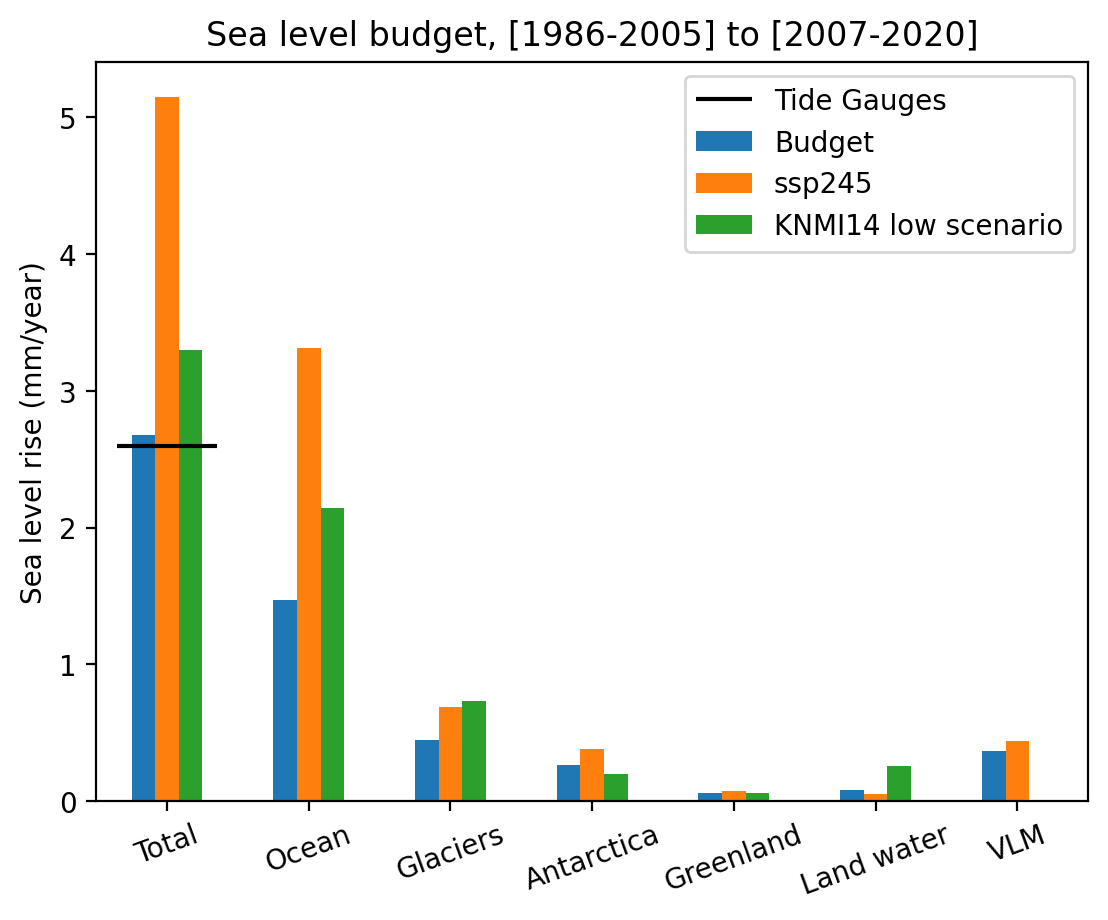

In [21]:
comp_df = comp_budget(ref_s, ref_e, sp, ep, KNMIsig_sub)
ax = comp_df.plot.bar(rot=20)
ax.hlines(y=tg_rate, xmin=-0.35, xmax=0.35, color='black', label='Tide Gauges')

#ax.set_ylim([0,4.2])
plt.legend()
plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' );

#plt.savefig(path_fig+'comp_budget_NoBiasCorr.pdf', dpi=150)

Text(0.5, 1.0, 'Sea level budget, [1986-2005] to [2007-2020]')

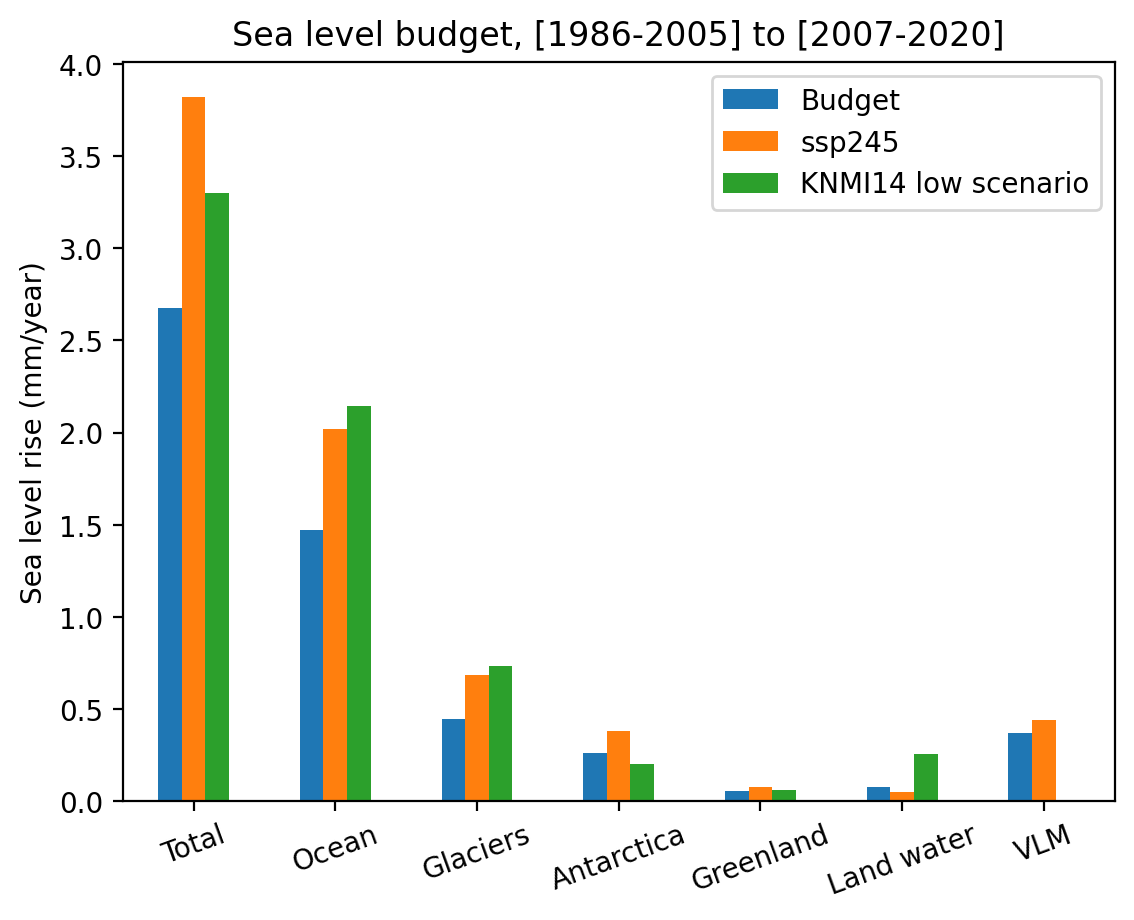

In [16]:
comp_df = comp_budget(ref_s, ref_e, sp, ep, KNMIsigBNW_sub)
ax = comp_df.plot.bar(rot=20)
#ax.set_ylim([0,4.2])
plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )

#plt.savefig(path_fig+'comp_budget_BiasCorrNoWind.pdf', dpi=150)

Text(0.5, 1.0, 'Sea level budget, [1986-2005] to [2007-2020]')

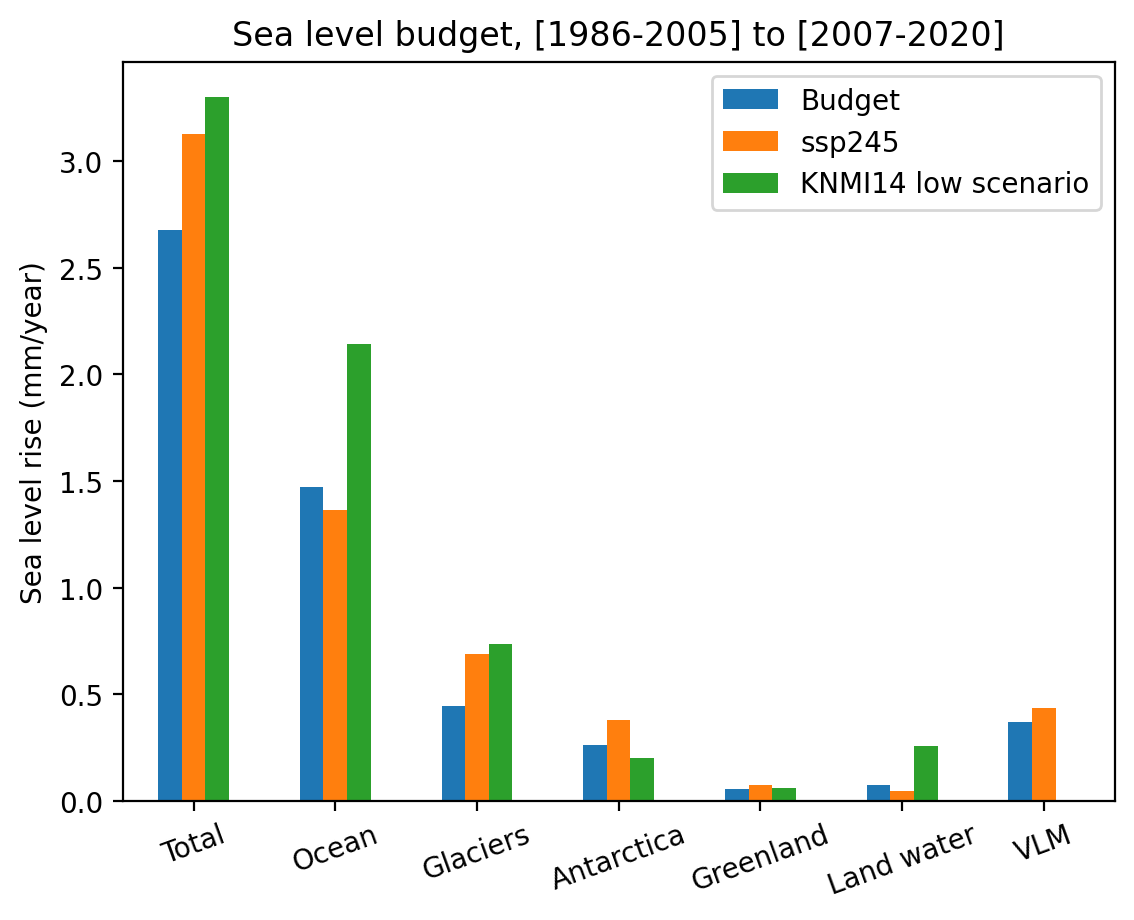

In [17]:
comp_df = comp_budget(ref_s, ref_e, sp, ep, KNMIsigBWW_sub)
ax = comp_df.plot.bar(rot=20)
#ax.set_ylim([0,4.2])
plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )

#plt.savefig(path_fig+'comp_budget_BiasCorrWithWind.pdf', dpi=150)

## Compare with a budget including more processes

- Separate local steric and wind

In [18]:
sp = 2007
ep = 2020
ref_s = 1986
ref_e = 2005

tot_years = (sp+ep)/2 - (ref_e+ref_s)/2

budget_diff = (budget_df.loc[sp:ep].mean() 
               - budget_df.loc[ref_s:ref_e].mean())/tot_years*10

budget_diff['Wind'], budget_diff['Nodal'], budget_diff['Pressure']

(-0.2924208153726523, -0.08331294406193611, 0.07563058075896684)

In [19]:
def comp_budget2(ref_s, ref_e, sp, ep, KNMIsig_sub):
    '''Make a dataframe that can easily be used to make a bar chart'''

    tot_years = (sp+ep)/2 - (ref_e+ref_s)/2

    sce = 'low' # 'low' or 'high'
    if sce == 'low':
        rcp_scen = 'ssp245'
    elif sce == 'high':
        rcp_scen = 'ssp585'

    budget_diff = (budget_df.loc[sp:ep].mean() 
                   - budget_df.loc[ref_s:ref_e].mean())/tot_years*10

    KNMI_sig_diff = KNMIsig_sub.sel(time=slice(sp,ep), percentiles=50
                                   ).mean(dim='time')/tot_years*10

    # Build a new dataframe for comparison purposes:
    index = ['Total', 'LocSteric', 'GloSteric','Glaciers', 'Antarctica', 
             'Greenland', 'Land water', 'VLM', 'Wind&IBE', 'Nodal']

    obs_budget = [budget_diff['Total'], budget_diff['LocSteric'], budget_diff['GloSteric'],
                  budget_diff['Glaciers'], budget_diff['Antarctica'], 
                  budget_diff['Greenland'], budget_diff['TWS'], budget_diff['GIA'],
                  budget_diff['Wind'] +  budget_diff['Pressure'], budget_diff['Nodal']]

    proj = [KNMI_sig_diff.sel(proc='Total_with_sub').values.item(), 
            KNMI_sig_diff.sel(proc='Local ocean').values.item(), 
            KNMI_sig_diff.sel(proc='Global steric').values.item(), 
            KNMI_sig_diff.sel(proc='Glaciers').values.item(),
            KNMI_sig_diff.sel(proc='sum anta.').values.item(), 
            KNMI_sig_diff.sel(proc='Greenland SMB').values.item() 
            + KNMI_sig_diff.sel(proc='Greenland dynamics').values.item(),
            KNMI_sig_diff.sel(proc='Landwater').values.item(),
            KNMI_sig_diff.sel(proc='Subsidence').values.item(),
            0,
            0]
    
    comp_df = pd.DataFrame({'Budget': obs_budget,
                            f'KNMI_signal_{rcp_scen}': proj}, 
                            index=index)
    return comp_df

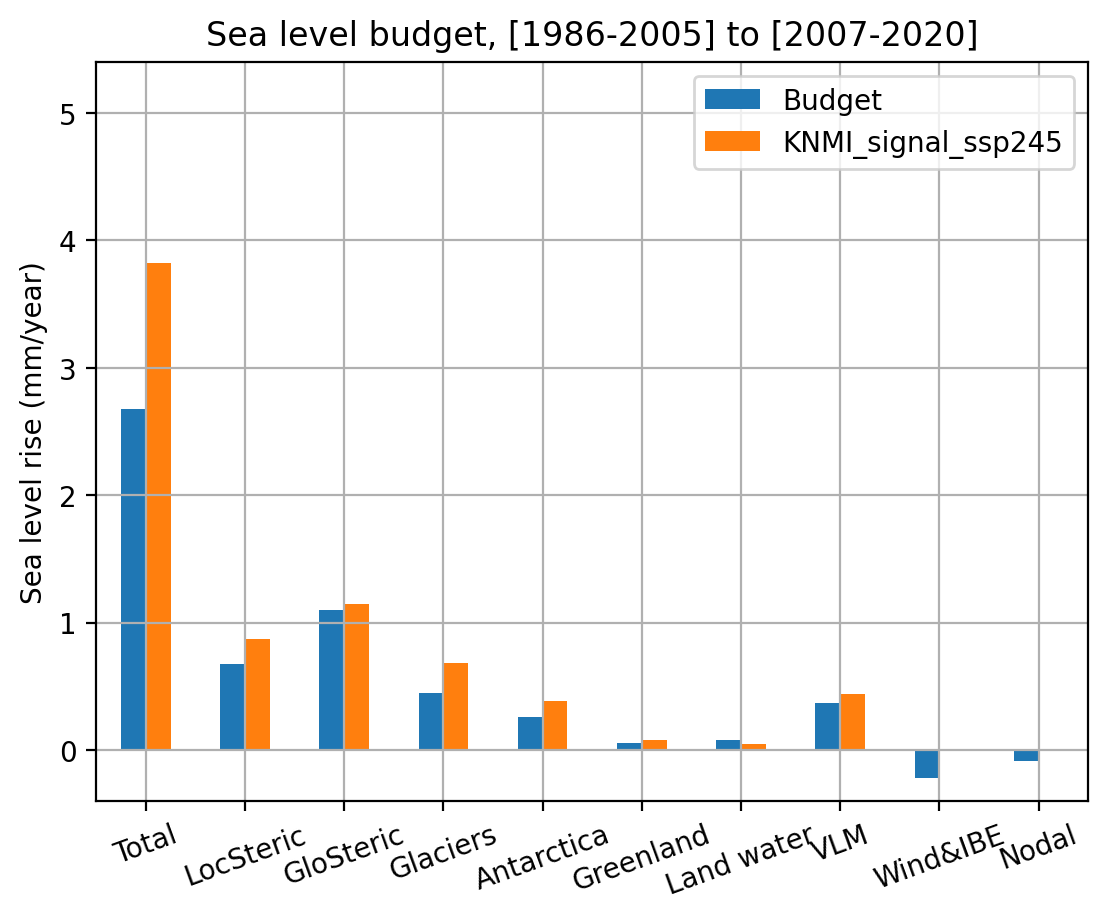

In [20]:
comp_df = comp_budget2(ref_s, ref_e, sp, ep, KNMIsigBNW_sub)
ax = comp_df.plot.bar(rot=20)
ax.set_ylim([-0.4,5.4])

plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )
plt.grid();

#plt.savefig(f'{path_fig}Comp_Budget_KS21.pdf', dpi=150)

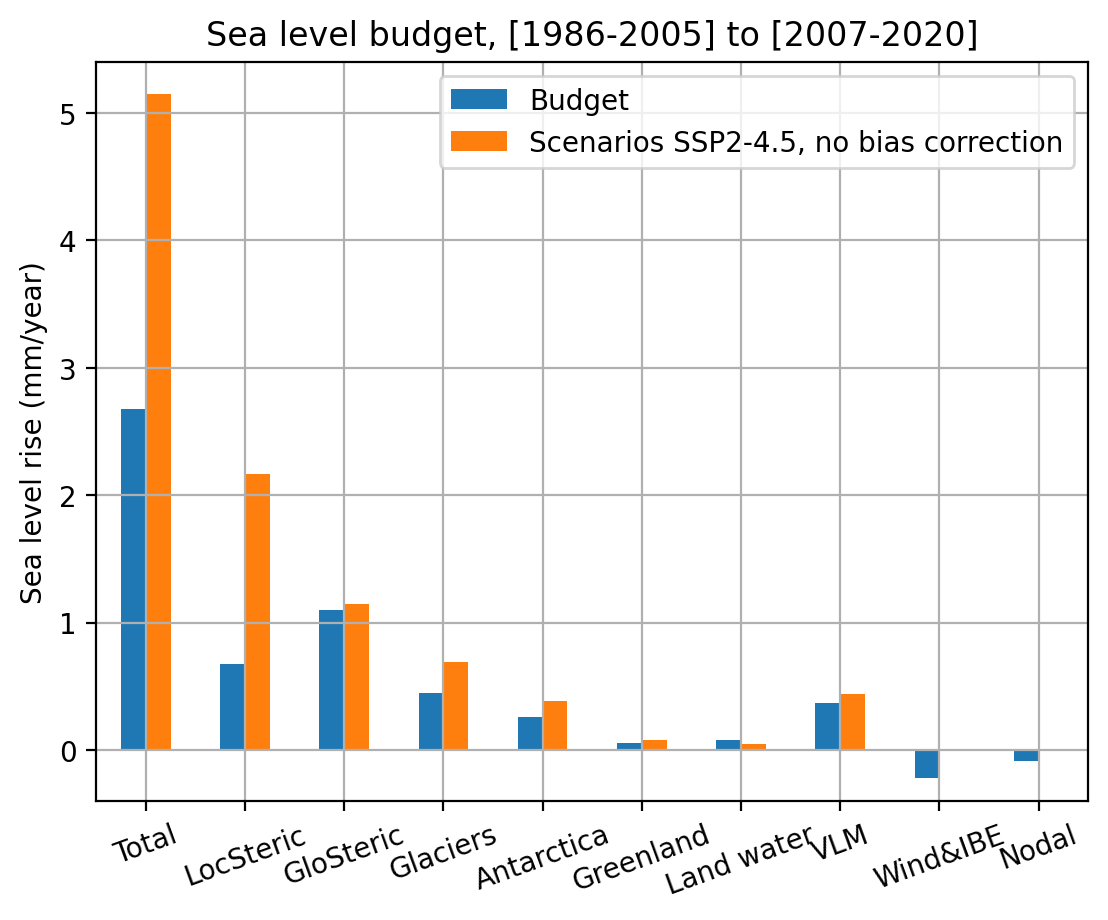

In [21]:
comp_df = comp_budget2(ref_s, ref_e, sp, ep, KNMIsig_sub)
comp_df.columns = ['Budget', 'Scenarios SSP2-4.5, no bias correction']
ax = comp_df.plot.bar(rot=20)
ax.set_ylim([-0.4,5.4])

plt.ylabel('Sea level rise (mm/year)')
plt.title('Sea level budget, ['+str(ref_s)+'-'+str(ref_e)+']'+' to ['+str(sp)+'-'+str(ep)+']' )
plt.grid();

#plt.savefig(f'{path_fig}Comp_Budget_KS21_no_bias_correction.pdf', dpi=150)